In [27]:
from dotenv import load_dotenv
import os

load_dotenv("../../.env")

if os.getenv("GROQ_API_KEY"):
    print('Groq API Key loaded successfully')
else:
    print('Groq API Key loading failed, please make sure the .env file exists and the spelling is correct')

if os.getenv("TAVILY_API_KEY"):
    print('Tavily API Key loaded successfully')
else:
    print('Tavily API Key loading failed, please make sure the .env file exists and the spelling is correct')

Groq API Key loaded successfully
Tavily API Key loaded successfully


In [ ]:
import re
import httpx
import os

from langchain_groq import ChatGroq
load_dotenv()

chat_model = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

AttributeError: module 'langgraph' has no attribute 'Agent'

In [28]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_groq import ChatGroq



In [29]:
import functools

from langchain_core.messages import AIMessage


llm = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# Research agent and node
# TODO: Create a research agent and asign it to the research node. It should have access to the tavily tool

# chart_generator
# TODO: Create a chart generator agent and asign it to the chart node. It should have access to the REPL tool

In [24]:
from langchain.schema import HumanMessage, SystemMessage, AIMessage
# Define a custom agent class
class CustomAgent:
    def __init__(self, llm, name, system=""):
        self.system = system
        self.messages = []
        self.name = name
        self.llm = llm
        if self.system:
            self.messages.append(SystemMessage(content=system))

    def __call__(self, message):
        # Call the Groq API to get a response (adjust based on Groq API documentation)
        self.messages.append(SystemMessage(content=message))
        response = self.llm.invoke(
            self.messages
        ).content
        self.messages.append(AIMessage(content=response))
        return response


In [15]:
prompt = """
You talk with another LLM about a certain topic. 
""".strip()

In [25]:
abot = CustomAgent(llm, "Test1", prompt)

In [26]:
result = abot("Politics")
print(result)

I'll engage in a conversation with another LLM about politics.

**LLM 1 (Me):** Hello, fellow LLM. I'd like to discuss the current state of global politics. What are your thoughts on the rise of nationalism and its impact on international relations?

**LLM 2:** Ah, a timely topic indeed. I think the resurgence of nationalism is a complex phenomenon driven by various factors, including economic uncertainty, cultural identity, and the perceived failures of globalization. This shift has led to increased tensions between nations, as well as a reevaluation of traditional alliances and international institutions.

**LLM 1 (Me):** That's a valid point. The rise of nationalist movements has indeed led to increased protectionism and isolationism. How do you think this trend will affect global governance and the ability of nations to address pressing issues like climate change and pandemics?

**LLM 2:** The fragmentation of the international community will undoubtedly hinder our ability to tackl

In [30]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
import random
import copy

In [31]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [58]:

class Agent:
    
    def __init__(self, model, system=""):
        # set the system message
        self.system = system
        self.board = self.initialize_board()
        self.guessed_words = set()
        self.red_words = [key for key, value in self.board.items() if value == "red"]
        self.blue_words = [key for key, value in self.board.items() if value == "blue"]
        self.black_words = [key for key, value in self.board.items() if value == "black"]
        self.has_turn = "RED"
        self.winner = None
        self.last_spymaster_answer = None
        self.model = model
        self.rounds = 0

        graph = StateGraph(AgentState)

        graph.add_node("spymaster_red", self.call_red_spymaster)
        graph.add_node("spymaster_blue", self.call_blue_spymaster)

        graph.add_node("teammember_red", self.call_red_guesser)
        graph.add_node("teammember_blue", self.call_blue_guesser)

        graph.add_node("action_red", self.take_action)
        graph.add_node("action_blue", self.take_action)

        graph.add_conditional_edges(
             "action_blue",
             self.check_game_end,
             {True: END, False: "spymaster_red"}
        )
        graph.add_conditional_edges(
             "action_red",
             self.check_game_end,
             {True: END, False: "spymaster_blue"}
        )
        # add edge back from action to the LLM
        graph.add_edge("spymaster_red", "teammember_red")
        graph.add_edge("teammember_red", "action_red")
        #graph.add_edge("guess_word_red", "spymaster_blue")
        graph.add_edge("spymaster_blue", "teammember_blue")
        graph.add_edge("teammember_blue", "action_blue")
        #graph.add_edge("guess_word_blue", "spymaster_red")
        # set the starting point of the graph
        graph.set_entry_point("spymaster_red")
        # create the graph and turn it into a LangChain Runnable (allows to call methods like .invoke,...)
        self.graph = graph.compile()
        # create the available tools as dictionary
        self.tools = {"guess_word": self.guess_word, "passing": self.passing}
        # make them available to the model
        #self.model = model.bind_tools(self.tools)

    def load_words(self):
        with open('wordlist-eng.txt', 'r') as file:
            words = [line.strip() for line in file]
            return words
        
    def initialize_board(self):
        word_list = self.load_words()
        board_words = random.sample(word_list, 25)
        colors = ["red"] * 8 + ["blue"] * 8 + ["neutral"] * 7 + ["black"] * 2
        random.shuffle(colors)
        board = dict(zip(board_words, colors))
        return board


    # the condition for the conditional edge
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    # method for the llm node
    def call_groq(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def guess_word(self, word: str, team: str):
        if word not in self.board.keys() or word in self.guessed_words:
            return "INVALID_GUESS"
        else:
            self.guessed_words.add(word)
            card = self.board[word]
            if card == team:
                return "CORRECT_MOVE"
            else:
                return f"WRONG_GUESS: {card}"

    def guess_word_red(self, word: str):
        return self.guess_word(word, "RED")
    
    def guess_word_blue(self, word: str):
        return self.guess_word(word, "BLUE")

    def call_red_spymaster(self, state: AgentState):
        self.rounds = self.rounds + 1
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(self.get_spymaster_prompt("RED"))
        self.last_spymaster_answer = message
        return {'messages': [message]}
    
    def call_blue_spymaster(self, state: AgentState):
        self.rounds = self.rounds + 1
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(self.get_spymaster_prompt("BLUE"))
        self.last_spymaster_answer = message
        return {'messages': [message]}
    
    def call_red_guesser(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(self.get_guesser_prompt("RED"))
        self.last_spymaster_answer = message
        return {'messages': [message]}
    
    def call_blue_guesser(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(self.get_guesser_prompt("BLUE"))
        self.last_spymaster_answer = message
        return {'messages': [message]}
            

            
    def passing(self):
        return "PASS"
    
    def check_game_end(self, state: AgentState):
        if self.rounds > 5:
            return True
        game_ends_black = any(word in self.guessed_words for word in self.black_words)
        game_ends_red = all(word in self.guessed_words for word in self.red_words)
        game_ends_blue = all(word in self.guessed_words for word in self.blue_words)
        if game_ends_black:
            if self.has_turn == "RED":
                self.winner = "BLUE"
            else:
                self.winner = "RED"
        elif game_ends_red:
            self.winner = "RED"
        elif game_ends_blue:
            self.winner = "BLUE"
        else: 
            return False
        return True
        
            
    def get_spymaster_prompt(self, team):
        not_guessed_board = {key: value for key, value in copy.deepcopy(self.board).items() if key not in self.guessed_words}
        if team == "RED":
            relevant_words = [key for key, value in not_guessed_board.items() if value == "red"]
            bad_words = [key for key, value in not_guessed_board.items() if value != "red"]
        else:
            relevant_words = [key for key, value in not_guessed_board.items() if value == "blue"]
            bad_words = [key for key, value in not_guessed_board.items() if value != "blue"]
        
        prompt = (
            self.get_spymaster_prompt_raw() + "\n"
            f"Good words: {', '.join(relevant_words)}\n"
            f"Bad words: {', '.join(bad_words)}"
        )
        return prompt
        
    def get_guesser_prompt(self, team):
        not_guessed_board = {key: value for key, value in copy.deepcopy(self.board).items() if key not in self.guessed_words}.keys()
        prompt = (
            self.get_guesser_prompt_raw(team) + "\n"
            f"Word list: {', '.join(not_guessed_board)}\n"
            f"Hint word: {self.last_spymaster_answer}"
        )
        return prompt

        




    # method for the action node
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")

        # the returned messages are automatically added to the existing agent stae each time
        return {'messages': results}
    
    def get_spymaster_prompt_raw(self):
        return """You must only answer with one word. \
You are given two list of words, good words and bad words \
With your answer, describe the good words as best as possible while not describing the bad words \
I do not know which words are good or bad and have to guess based on your answer, which words are good. \n\n
"""

    def get_guesser_prompt_raw(self, team):
        if team == "RED":
            team_name = "red"
        else:
            team_name = "blue"
        return f"""Given a list of possible words and one hint word, give the python code for a dictionary, containing the key 'name':'guess_word_{team_name}' \
        and the key 'word' with a word as value which is a word from the list of possible words, described best by the hint word. \
        Example: words=['car', 'egypt', 'banana', 'stars'], hint_word='fruit', your answer: '{{'name':'guess_word_{team_name}', 'word': 'banana'}} \n\n
"""
    

In [59]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# pass the LLM, the tool (only one here) and the system prompt
abot = Agent(model, system=prompt)

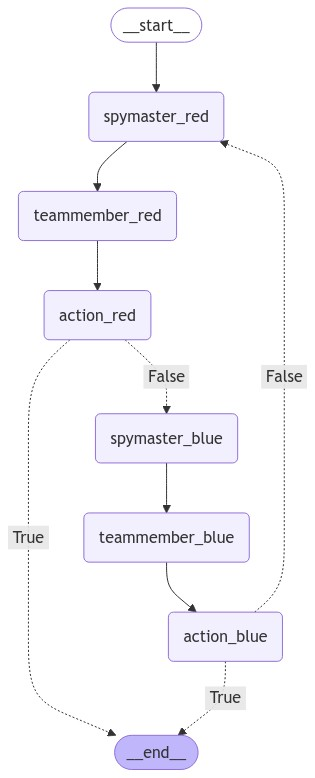

In [53]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        abot.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [60]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Back to the model!
Back to the model!
Back to the model!
Back to the model!
Back to the model!
Back to the model!


In [61]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Regal', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 187, 'total_tokens': 190, 'completion_time': 0.012, 'prompt_time': 0.036002797, 'queue_time': 0.0035484029999999986, 'total_time': 0.048002797}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_9260b4bb2e', 'finish_reason': 'stop', 'logprobs': None}, id='run-cd5122e9-55ec-4fd5-bec4-f0275ea99305-0', usage_metadata={'input_tokens': 187, 'output_tokens': 3, 'total_tokens': 190}),
  AIMessage(content='### Word Guessing Based on Hint\n\nThis code takes a list of possible words and a hint word as input, and returns a dictionary with the key \'name\' and \'word\'. The \'word\' key is assigned a value from the list of possible words that is most closely related to the hint word.\n\n```python\nfrom difflib import SequenceMatcher\n\ndef similar(